In [40]:
import json

import numpy as np
import torch
from PIL import Image
from torchvision.utils import make_grid
from torchvision import transforms
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from collections import OrderedDict

from datasets import get_CIFAR10, get_SVHN, postprocess, preprocess, get_CELEBA
from model import Glow


device = torch.device("cuda")

output_folder = 'output/'

conf = OmegaConf.load('config_train.yaml')    
image_shape, num_classes, celeba_data, celeba = get_CELEBA(conf.augment, conf.dataroot, True)
#image_shape, num_classes, _, test_svhn = get_SVHN(conf.augment, conf.dataroot, conf.download)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
print(image_shape)

(128, 128, 3)


In [3]:
model_name = './mike_weights/epoch=6.ckpt'
checkpoint = torch.load(model_name, map_location=device)

## CHECK SAMPLING

In [4]:
model = Glow(image_shape, conf.hidden_channels, conf.K, conf.L, conf.actnorm_scale,
             conf.flow_permutation, conf.flow_coupling, conf.LU_decomposed, num_classes,
             conf.learn_top, conf.y_condition)

In [5]:
keys_orig = list(model.state_dict().keys())
keys_pl =  list(checkpoint['state_dict'].keys())
#keys_pl = [k.replace('model.','') for k in keys_pl]

In [67]:
#set(keys_pl).intersection(set(keys_orig))

In [6]:
print(len(keys_pl), len(keys_orig))

1540 1540


In [5]:
new_state_dict = OrderedDict()

for key, value in checkpoint['state_dict'].items():
    new_key = key.replace('model.','')
    new_state_dict[new_key] = value

In [12]:
keys_orig[:2]

['prior_h', 'flow.layers.1.actnorm.bias']

In [13]:
keys_pl[:2]

['model.prior_h', 'model.flow.layers.1.actnorm.bias']

In [6]:
model = Glow(image_shape, conf.hidden_channels, conf.K, conf.L, conf.actnorm_scale,
             conf.flow_permutation, conf.flow_coupling, conf.LU_decomposed, num_classes,
             conf.learn_top, conf.y_condition)

model.load_state_dict(new_state_dict)
model.set_actnorm_init()

model = model.to(device)

model = model.eval()

In [7]:
del new_state_dict
del checkpoint

In [8]:
def sample(model):
    with torch.no_grad():
        if conf.y_condition:
            y = torch.eye(num_classes)
            y = y.repeat(batch_size // num_classes + 1)
            y = y[:32, :].to(device) # number hardcoded in model for now
        else:
            y = None

        images = postprocess(model(y_onehot=y, temperature=0.8, reverse=True))
    return images.cpu()

In [9]:
def min_max(arr):
    mn = arr.min()
    mx = arr.max()
    return (arr - mn)/(mx-mn)

(-0.5, 781.5, 651.5, -0.5)

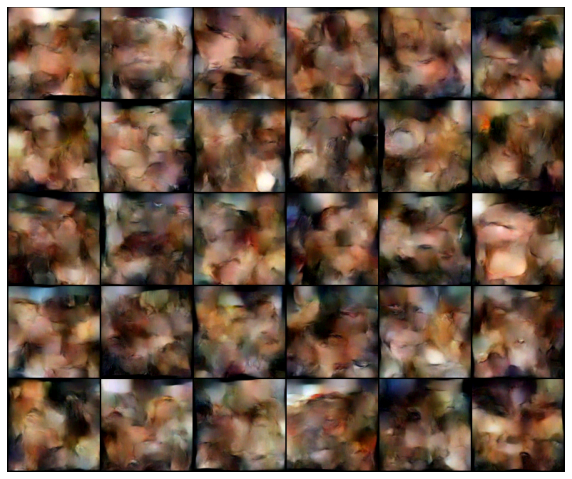

In [10]:
images = sample(model)
grid = make_grid(images[:30], nrow=6, normalize=False).permute(1,2,0).numpy()

plt.figure(figsize=(10,10))
plt.imshow(min_max(grid))
plt.axis('off')

# CHECK DIRECT FLOW

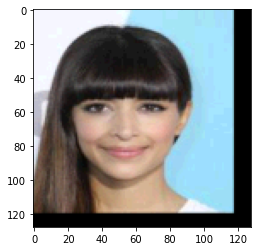

In [12]:
idx = 120
plt.imshow(min_max(celeba_data[idx][0].permute(1,2,0).numpy()))

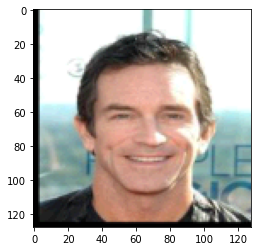

In [13]:
idx = 37
plt.imshow(min_max(celeba_data[idx][0].permute(1,2,0).numpy()))

In [8]:
convert_to_tensor = transforms.ToTensor()

In [34]:
# img_tensor =  preprocess(celeba_data[idx][0]).unsqueeze(0)
# print(f'tensor shape {img_tensor.shape}')

tensor shape torch.Size([1, 3, 128, 128])


In [36]:
# img_from_tensor = img_tensor.squeeze(0).permute(1,2,0).numpy()
# plt.imshow(min_max(img_from_tensor))

In [42]:
model.cpu()
img_tensor = celeba_data[120][0].unsqueeze(0)
woman, _, _ = model(x=img_tensor, reverse=False)
img_tensor = celeba_data[37][0].unsqueeze(0)
man, _, _ = model(x=img_tensor, reverse=False)
print(f'Out shape: {woman.shape}')
print(f'Out shape: {man.shape}')

Out shape: torch.Size([1, 192, 16, 16])
Out shape: torch.Size([1, 192, 16, 16])


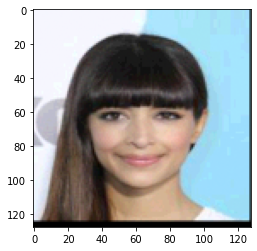

In [15]:
woman_back =  model(z=woman, y_onehot=None, temperature=None, reverse=True)
woman_from_tensor = woman_back.squeeze(0).permute(1,2,0).cpu().numpy()
plt.imshow(min_max(woman_from_tensor))

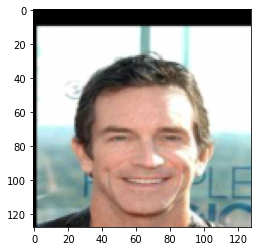

In [43]:
man_back =  model(z=man, y_onehot=None, temperature=None, reverse=True)
man_from_tensor = man_back.squeeze(0).permute(1,2,0).cpu().numpy()
plt.imshow(min_max(man_from_tensor))

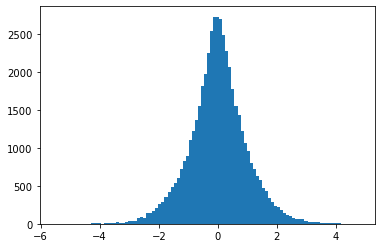

In [18]:
man.shape
plt.hist(man.squeeze(0).permute(1,2,0).detach().cpu().numpy().reshape(-1), bins=100);

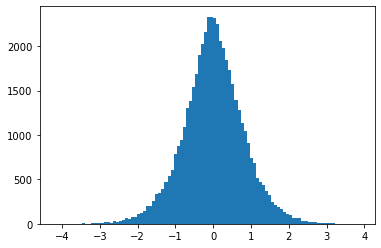

In [20]:
plt.hist(woman.squeeze(0).permute(1,2,0).detach().cpu().numpy().reshape(-1), bins=100);

In [19]:
woman.squeeze(0).permute(1,2,0).detach().cpu().numpy().reshape(-1).std()

0.79525936

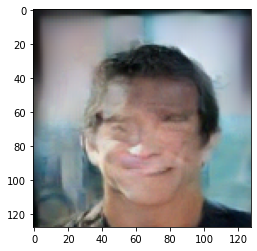

In [21]:
new_z = 0.5*woman + 0.7*man
z_back =  model(z=new_z, y_onehot=None, temperature=None, reverse=True)
z_from_tensor = z_back.squeeze(0).permute(1,2,0).cpu().numpy()
plt.imshow(min_max(z_from_tensor))

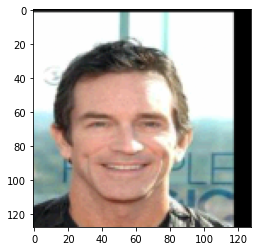

In [160]:
new_z = man
z_back =  model(z=new_z, y_onehot=None, temperature=None, reverse=True)
z_from_tensor = z_back.squeeze(0).permute(1,2,0).cpu().numpy()
plt.imshow(min_max(z_from_tensor))

### TEST A NEW IMAGE NOT FROM THE DATASET

In [50]:
im = Image.open('./test_image.jpg')
image = im.crop((160, 0, 660, 540)).resize((128, 128))
new_image = np.array(image)

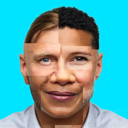

In [62]:
image

In [58]:
convert_to_tensor = transforms.ToTensor()
im_tensor = convert_to_tensor(new_image).unsqueeze(0)
im_tensor.shape

torch.Size([1, 3, 128, 128])

### NEW IMAGE IN  GAUSS 
#### our latent vector

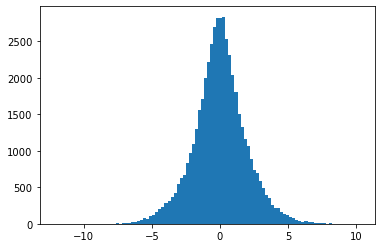

In [60]:
new_face, _, _ = model(x=im_tensor.cuda(), reverse=False)
plt.hist(new_face.squeeze(0).permute(1,2,0).detach().cpu().numpy().reshape(-1), bins=100);

### NEW IMAGE RECOVERED

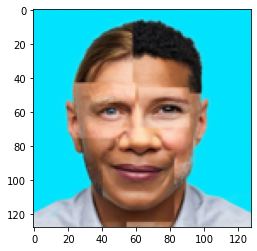

In [61]:
z_back =  model(z=new_face, y_onehot=None, temperature=None, reverse=True)
z_from_tensor = z_back.squeeze(0).permute(1,2,0).cpu().numpy()
plt.imshow(min_max(z_from_tensor))

#### Image recovered from the latent space

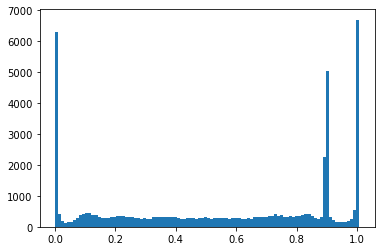

In [69]:
plt.hist(z_from_tensor.reshape(-1), bins=100);

### FIND BALD VECTOR

In [10]:
from tqdm import tqdm

bald_people = []

for i in tqdm(range(len(celeba_data))):
    if celeba_data[i][1][4] == 1:
        bald_people.append(celeba_data[i][0])
    if len(bald_people) > 100:
        break

  3%|▎         | 4248/162770 [00:17<10:47, 244.81it/s]


In [11]:
del celeba_data
del celeba

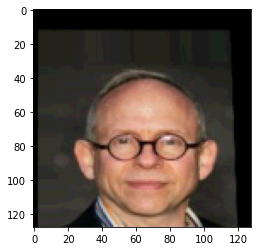

In [12]:
plt.imshow(min_max(bald_people[18].permute(1,2,0).numpy()))

In [13]:
bald_people = [p.unsqueeze(0) for p in bald_people]

bald_people_tensor = torch.cat(bald_people, axis=0)
print(bald_people_tensor.shape)

torch.Size([101, 3, 128, 128])


In [48]:
import gc 
  
# Returns the number of 
# objects it has collected 
# and deallocated 
collected = gc.collect() 
  
# Prints Garbage collector  
# as 0 object 
print("Garbage collector: collected", 
          "%d objects." % collected) 

Garbage collector: collected 128 objects.


In [ ]:
bald_latent = []
model.cpu()
for i in tqdm(range(bald_people_tensor.shape[0])):
    torch.cuda.empty_cache()
    gc.collect()
    try:
        img_tensor = bald_people_tensor[i].unsqueeze(0).cpu()
        latent, _, _ = model(x=img_tensor, reverse=False)
        latent = latent.cpu()
        del img_tensor
        bald_latent.append(latent)
        torch.cuda.empty_cache()
        gc.collect()
    except:
        continue

  0%|          | 0/101 [00:00<?, ?it/s]

In [63]:
latent_all = torch.cat(bald_latent, axis=0)
latent_all.shape

torch.Size([27, 192, 16, 16])

In [64]:
bald_latent_mean = latent_all.mean(0).unsqueeze(0)
bald_latent_mean.shape

torch.Size([1, 192, 16, 16])

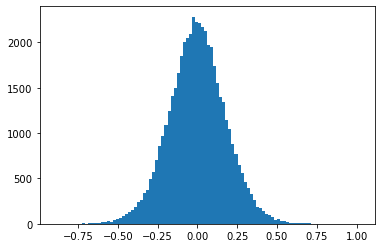

In [65]:
plt.hist(bald_latent_mean.squeeze(0).permute(1,2,0).detach().cpu().numpy().reshape(-1), bins=100);

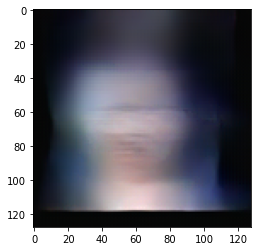

In [66]:
# new_z = 0.8*man + 0.2*bald_latent_mean
model.cpu()
z_back =  model(z=bald_latent_mean, y_onehot=None, temperature=None, reverse=True)
z_from_tensor = z_back.squeeze(0).permute(1,2,0).cpu().numpy()
plt.imshow(min_max(z_from_tensor))

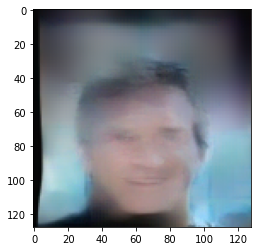

In [67]:
new_z = 0.4*man.cpu() + 0.6*bald_latent_mean.cpu()
z_back =  model(z=new_z, y_onehot=None, temperature=None, reverse=True)
z_from_tensor = z_back.squeeze(0).permute(1,2,0).cpu().numpy()
plt.imshow(min_max(z_from_tensor))